In [1]:
import asimov_database as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pr = ad.ParquetReader()



class Causality:
    def __init__(self, dol, wdo, date):
        self.date = date
        self.dol = dol
        self.wdo = wdo
    
    def _files(self):

        #Carrega e Trata os arquivos
        level_data = pr.get_parquet(self.dol, self.date, "level-book")
        events = pr.get_parquet(self.dol, self.date, "events")["incremental"].read().to_pandas()
        snap = pr.get_parquet(self.dol, self.date, "events")["snapshot"].read().to_pandas()

        level_data_wdo = pr.get_parquet(self.wdo, self.date, "level-book")
        events_wdo = pr.get_parquet(self.wdo, self.date, "events")["incremental"].read().to_pandas()
        snap_wdo = pr.get_parquet(self.wdo, self.date, "events")["snapshot"].read().to_pandas()

        bid_price = level_data["bid_price"].read().to_pandas()
        bid_quantity = level_data["bid_quantity"].read().to_pandas()
        bid_inc_code = level_data["bid_inc_code"].read().to_pandas()

        ask_price = level_data["ask_price"].read().to_pandas()
        ask_quantity = level_data["ask_quantity"].read().to_pandas()
        ask_inc_code = level_data["ask_inc_code"].read().to_pandas()

        bid_price_wdo= level_data_wdo["bid_price"].read().to_pandas()
        bid_quantity_wdo = level_data_wdo["bid_quantity"].read().to_pandas()
        bid_inc_code_wdo = level_data_wdo["bid_inc_code"].read().to_pandas()

        ask_price_wdo = level_data_wdo["ask_price"].read().to_pandas()
        ask_quantity_wdo = level_data_wdo["ask_quantity"].read().to_pandas()
        ask_inc_code_wdo = level_data_wdo["ask_inc_code"].read().to_pandas()

        bid_wdo = bid_price_wdo[["bid_0"]].copy()
        bid_quantity_wdo.columns = ["bid_quantity_wdo_{}".format(i) for i in range(bid_quantity_wdo.shape[1])]
        bid_wdo["bid_quantity_wdo_0"] = bid_quantity_wdo["bid_quantity_wdo_0"]
        bid_wdo["i_bid_wdo"] = bid_inc_code_wdo[0]#.apply(lambda x: "B_" + str(x))
        bid_wdo.rename({'bid_0' : 'bid_wdo_0'}, axis = 1, inplace = True )

        bid = bid_price[["bid_0"]].copy()
        bid_quantity.columns = ["bid_quantity_{}".format(i) for i in range(bid_quantity.shape[1])]
        bid["bid_quantity_0"] = bid_quantity["bid_quantity_0"]
        bid["i_bid"] = bid_inc_code[0]

        ask = ask_price[["ask_0"]].copy()
        ask_quantity.columns = ["ask_quantity_{}".format(i) for i in range(ask_quantity.shape[1])]
        ask["ask_quantity_0"] = ask_quantity["ask_quantity_0"]
        ask["i_ask"] =ask_inc_code[0]#.apply(lambda x: "A_" + str(x))

        ask_wdo = ask_price_wdo[["ask_0"]].copy()

        ask_wdo.rename({'ask_0':'ask_wdo_0'}, axis = 1, inplace= True)

        ask_quantity_wdo.columns = ["ask_quantity_wdo_{}".format(i) for i in range(ask_quantity_wdo.shape[1])]
        ask_wdo["ask_quantity_wdo_0"] = ask_quantity_wdo["ask_quantity_wdo_0"]
        ask_wdo["i_ask_wdo"] =ask_inc_code_wdo[0]

        events.reset_index(inplace=True)
        events_wdo.reset_index(inplace=True)

        #Procura por atualizações provenientes da bolsa e retira da versão final
        valor_dol = np.setdiff1d(events['i'].values, bid_inc_code[0].values)
        valor_dol   

        retira_dol = np.setdiff1d(valor_dol,ask_inc_code[0].values)
        retira_dol

        valor_wdo_ask = np.setdiff1d(events_wdo['i'].values, bid_inc_code_wdo[0].values)
        valor_wdo_ask

        retira_wdo_ask = np.setdiff1d(valor_wdo_ask,ask_inc_code_wdo[0].values)
        retira_wdo_ask

        valor_wdo_bid = np.setdiff1d(events_wdo['i'].values, ask_inc_code_wdo[0].values)
        valor_wdo_bid

        retira_wdo_bid = np.setdiff1d(valor_wdo_bid, bid_inc_code_wdo[0].values)
        retira_wdo_bid

        if len(retira_dol) != 0:
            for i in retira_dol:
                events = events[events['i'] != i]


        if len(retira_wdo_bid) != 0:
            for i in retira_wdo_bid:
                events_wdo = events_wdo[events_wdo['i'] != i]
        
        # Busca os arquivos de eventos
        self.events = events
        self.events_wdo = events_wdo


        #Cria os arquivos de bid e ask
        bid["msg_seq_num"] = events[events["side"] != "A"]["msg_seq_num"].values
        bid['event_type'] =  events[events["side"] != "A"]["event_type"].values
        
        bid['i'] =  events[events["side"] != "A"]["i"].values
        ask["i"] = events[events["side"] != "B"]["i"].values
        
        ask["msg_seq_num"] = events[events["side"] != "B"]["msg_seq_num"].values
        ask["event_type"] = events[events["side"] != "B"]["event_type"].values
        
        bid['position'] =  events[events["side"] != "A"]["position"].values
        ask["position"] = events[events["side"] != "B"]["position"].values
        
        
        bid_wdo["msg_seq_num"] = events_wdo[events_wdo["side"] != "A"]["msg_seq_num"].values
        ask_wdo["msg_seq_num"] = events_wdo[events_wdo["side"] != "B"]["msg_seq_num"].values
        
        bid_wdo["position"] = events_wdo[events_wdo["side"] != "A"]["position"].values
        ask_wdo["position"] = events_wdo[events_wdo["side"] != "B"]["position"].values
        
        bid_wdo["event_type"] = events_wdo[events_wdo["side"] != "A"]["event_type"].values
        ask_wdo["event_type"] = events_wdo[events_wdo["side"] != "B"]["event_type"].values
        
        bid_wdo["i"] = events_wdo[events_wdo["side"] != "A"]["i"].values
        ask_wdo["i"] = events_wdo[events_wdo["side"] != "B"]["i"].values
        
        ask_wdo['side'] = 'A'
        ask['side'] = 'A'
        
        bid_wdo['side'] = 'B'
        bid['side'] = 'B'

        #Cria a versao final ja preenchendo os espacos vazios com os correspondentes valores
        df = pd.concat([ask, bid]).sort_values(by='i', kind = 'mergesort').reset_index()
        dl = pd.concat([ask_wdo, bid_wdo]).sort_values(by='i', kind = 'mergesort').reset_index()

        df['symbol'] = 'DOL'
        dl['symbol'] = 'WDO'
        df.ffill(inplace=True)
        df.dropna(inplace=True)
        dl.ffill(inplace=True)
        dl.dropna(inplace=True)
        
        total = pd.concat([df, dl]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()

        total.ffill(inplace=True)
        total.dropna(inplace=True)

        total_ = total[['index', 'event_type', 'side',  'symbol', 'msg_seq_num', 'ask_0', 'ask_quantity_0', 'bid_0', 'bid_quantity_0', 'ask_wdo_0', 'ask_quantity_wdo_0', 'bid_wdo_0', 'bid_quantity_wdo_0', 'position']][ (total['ask_0'] != 0) & (total['bid_0'] != 0)]

        total_['spread_dol'] = total['ask_0'] - total['bid_0']
        total_['spread_wdo'] = total['ask_wdo_0'] - total['bid_wdo_0']
                
        
        #Procura pelo primeiro momento de mercado estável
        begin = np.where( (total_['spread_wdo'] == 0.5) & (total_['spread_dol'] == 0.5) & (total_['ask_0'] == total_['ask_wdo_0']) & (total_['bid_0'] == total_['bid_wdo_0']))[0][0]

        total_.rename({'index' : 'timestamp'}, axis = 1, inplace = True)
             
        # Inicia análise no primeiro momento de estabilidade
        slice_ = total_.loc[begin:]
               
        #Calcula mid price
        slice_['mid_price'] = (slice_['ask_0'] + slice_['bid_0'])/2.0
        slice_['mid_price_wdo'] = (slice_['ask_wdo_0'] + slice_['bid_wdo_0'])/2.0
        
        teste_ = slice_.copy()
        self.trial = teste_


#         #Filtras msg_seq_number e observa apenas o ultimo evento ocorrido
#         slice_['repeat'] = False
#         slice_['repeat'][slice_['msg_seq_num'] != slice_['msg_seq_num'].shift(-1)] = True
#         slice_  = slice_[slice_['repeat']]
#         self.total__= slice_
#         slice_ = slice_.drop(['repeat', 'event_type', 'symbol', 'side'], axis =1).reset_index()

#         #Procura primeiro instance de spread aberto
#         index_ = np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )[0]

#         #Procura as posicoes no vetor anterior, onde os momento de spread aberto nao sao consecutivos
#         position = np.where(np.diff(np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )) != 1)[1] +1

#         #Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de instabilidade
#         A = []
#         for i in position:
#             A.append(index_[i])

            
            
#         ############################################################
# #         #Cria um dict com o evento de distorçao e o evento anterior
# #         frame = pd.DataFrame()
# #         dict_ = {}
# #         j=0
# #         for i in A:
# #             dict_[j] = frame.append(slice_.loc[i-1:i])
# #             j+=1


# #         for i in dict_.keys():
# #             dict_[i] = dict_[i].diff()

#         #########################################################

#         # distortion = pd.concat(dict_).reset_index()

#         # mover = distortion.dropna()[['ask_0', 'bid_0', 'ask_wdo_0', 'bid_wdo_0' ]]
#         # mover[mover['ask_0'] != 0].count()
#         # mover[mover['bid_0'] != 0].count()
#         # mover[mover['ask_wdo_0'] != 0].count()
#         # mover[mover['bid_wdo_0'] != 0].count()

#         #Cria um dict com o evento de distorçao e 300 eventos posteriores e o evento anterior
#         frame_next = pd.DataFrame()
#         dict_next = {}
#         j=0
#         for i in A:
#             dict_next[j] = frame_next.append(slice_.loc[i-1:i+300])
#             j+=1

#         dict_next_aux = {}
#         for i in dict_next.keys():
#             dict_next_aux[i] = dict_next[i].diff()

#         for i in dict_next.keys():
#             dict_next_aux[i]['spread_dol'] = dict_next[i]['spread_dol']
#             dict_next_aux[i]['spread_wdo'] = dict_next[i]['spread_wdo']
#             dict_next_aux[i]['msg_seq_num'] = dict_next[i]['msg_seq_num'] 

#         return dict_next_aux

        # distortion_next = pd.concat(dict_next_aux).reset_index()

    # Cria novas colunas do dataframe com valores que correspondem ao trend do movimento
    def func(self, dataframe):
        dataframe['movement_dol'] = [-1 if x < 0 else 0 if x == 0 else 1 for x in dataframe['mid_price']]
        dataframe['movement_wdo'] = [-1 if x < 0 else 0 if x == 0 else 1 for x in dataframe['mid_price_wdo']]
#         # dataframe = self._files()
#         dataframe.loc[dataframe['mid_price'] < 0, 'movement_dol'] = -1
#         dataframe.loc[dataframe['mid_price']  == 0, 'movement_dol'] = 0
#         dataframe.loc[dataframe['mid_price']  > 0, 'movement_dol'] = 1
#         dataframe.loc[dataframe['mid_price_wdo'] < 0, 'movement_wdo'] = -1
#         dataframe.loc[dataframe['mid_price_wdo']  == 0, 'movement_wdo'] = 0
#         dataframe.loc[dataframe['mid_price_wdo']  > 0, 'movement_wdo'] = 1
        return dataframe 

    def organiza(self):

        dict_next_aux = self._files()
        
        # Aplica a funcao anterior ao dataframe
        df = {}
        for i in dict_next_aux.keys():
            df[i] = self.func(dict_next_aux[i])[['movement_dol', 'movement_wdo',  'mid_price', 'mid_price_wdo', 'msg_seq_num']].dropna()
        
#         for i in dict_next_aux.keys():
#             df[i].dropna(inplace = True)

        # Procura no dict de dataframes o primeiro momento onde todos os comportamentos ocorrem no evento de distorçao 
        for i in df.keys():
            if (len(np.where(df[i]['movement_wdo'] == 1)[0]) != 0)  and (len(np.where(df[i]['movement_wdo'] == -1)[0]) != 0) and (len(np.where(df[i]['movement_dol'] == 1)[0]) != 0) and (len(np.where(df[i]['movement_dol'] == -1)[0]) != 0):
                break
        
        a = i
        return df, a

    def operacoes(self): 
        
        self.A,self.B,self.C,self.D,self.E,self.F,self.G,self.H = ([] for i in range(8))
        df, begin_ = self.organiza()
        self.aux_dol = 0
        self.aux_wdo = 0
        self.follow_up  = 0
        self.not_follow_up = 0
        self.follow_down = 0
        self.not_follow_down = 0
        self.follow_up_wdo  = 0
        self.not_follow_up_wdo = 0
        self.follow_down_wdo = 0
        self.not_follow_down_wdo = 0
#         self.cum_sum_wdo_WDO = {}
#         self.cum_sum_dol_WDO = {}
#         self.cum_sum_wdo_DOL = {}
#         self.cum_sum_dol_DOL = {}

        ###Inicia do primeiro momento nao vazio, ate o final do dict
        for i in range(begin_,max(df.keys())):
#             self.cum_sum_wdo_WDO[i] = {}
#             self.cum_sum_dol_WDO[i] = {}
#             self.cum_sum_wdo_DOL[i] = {}
#             self.cum_sum_dol_DOL[i] = {}
            df[i].reset_index(inplace=True) #Reinicia index para fazer slice
            for j in range(max(len(np.where(df[i]['movement_wdo'] == 1)[0]), len(np.where(df[i]['movement_wdo'] == -1)[0]), len(np.where(df[i]['movement_dol'] == 1)[0]), len(np.where(df[i]['movement_dol'] == -1)[0]))):
                a_ = np.where(df[i]['movement_wdo'] == 1)[0]
                b_ = np.where(df[i]['movement_wdo'] == -1)[0]
                c_ = np.where(df[i]['movement_dol'] == 1)[0]
                d_ = np.where(df[i]['movement_dol'] == -1)[0]
                if (len(a_) != 0)  and (len(b_) != 0) and (len(c_) != 0) and (len(d_) != 0):
                    ## Checa para ver se o WDO foi responsavel pelo primeiro movimento 
                    if min(a_[0], b_[0]) <  min(c_[0], d_[0]):
                        self.aux_wdo+=1
                        ## Checa para ver se o primeiro movimento foi up ou down 
                        if a_[0] < b_[0]:
                            steps = b_[0] # Determina o tamanho do slice no DataFrame
                            if c_[0] < steps:                                
                                self.A.append(df[i]['msg_seq_num'].values[a_[0]])
                                self.follow_up_wdo +=1
#                                 self.cum_sum_wdo_WDO[i][j] = df[i]['mid_price_wdo'].loc[a_[0]:steps-1].sum()
#                                 self.cum_sum_dol_WDO[i][j] = df[i]['mid_price'].loc[c_[0]:steps-1].sum()
                            else:
                                self.B.append(df[i]['msg_seq_num'].values[a_[0]])
                                self.not_follow_up_wdo +=1  
                        else:
                            steps = a_[0]
                            if d_[0] < steps:
                                self.C.append(df[i]['msg_seq_num'].values[b_[0]])
                                self.follow_down_wdo +=1
#                                 self.cum_sum_wdo_WDO[i][j] = df[i]['mid_price_wdo'].loc[b_[0]:steps-1].sum()
#                                 self.cum_sum_dol_WDO[i][j] = df[i]['mid_price'].loc[d_[0]:steps-1].sum()
                            else:
                                self.D.append(df[i]['msg_seq_num'].values[b_[0]])
                                self.not_follow_down_wdo +=1
                    else:
                        self.aux_dol+=1
                        if c_[0] < d_[0]:
                            steps = d_[0]
                            if a_[0] < steps:
                                self.E.append(df[i]['msg_seq_num'].values[c_[0]])
                                self.follow_up +=1
#                                 self.cum_sum_wdo_DOL[i][j] = df[i]['mid_price_wdo'].loc[a_[0]:steps-1].sum()
#                                 self.cum_sum_dol_DOL[i][j] = df[i]['mid_price'].loc[c_[0]:steps-1].sum()
                            else:
                                self.F.append(df[i]['msg_seq_num'].values[c_[0]])
                                self.not_follow_up +=1
                        else:
                            steps = c_[0]
                            if b_[0] < steps:
                                self.G.append(df[i]['msg_seq_num'].values[d_[0]])
                                self.follow_down +=1
#                                 self.cum_sum_wdo_DOL[i][j] = df[i]['mid_price_wdo'].loc[b_[0]:steps-1].sum()
#                                 self.cum_sum_dol_DOL[i][j] = df[i]['mid_price'].loc[d_[0]:steps-1].sum()
                            else:
                                self.H.append(df[i]['msg_seq_num'].values[d_[0]])
                                self.not_follow_down +=1

                df[i] = df[i].loc[steps:]
#                 df[i].dropna(inplace = True)





In [4]:
from asimov_strategy.managers.manager import Manager

In [5]:
manager = Manager()
# all_trades = manager._get_all_possible_trades('2020-01-06', 'Taker', {'signal' : 'insert_wo_trades'})  

[ Asynch ] STARTING THREAD. _run


## Whole month (JAN & DEZ) analysis


In [2]:
DATE_JAN = [
 '2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09', 
 '2020-01-10',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-20',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-27']

In [12]:
dict_delete = {}
dict_from = {}
# date_ = '2020-01-03'
j= 0
DOL = 'DOLG20'
WDO = 'WDOG20'


for date_ in DATE_JAN:
  
    e = Causality(DOL, WDO, date_)
    dl= e._files()
    dataframe_ = e.trial.copy()


    #     df = e._files()
    all_trades_monte_carlo = manager._get_all_possible_trades(date_, 'Taker', {'signal' : 'insert_w_trades'})  
    MSG_SEQ = []

    for i in range(len(all_trades_monte_carlo)):
        MSG_SEQ.append(all_trades_monte_carlo[i].get('react_msg_seq_num'))

    unique_msg = list(set(MSG_SEQ))

    index_of_trades = dataframe_[(dataframe_['msg_seq_num'].isin(unique_msg)) & (dataframe_['event_type'] == 'INSERT')].index
    index_ = index_of_trades

    dataframe_['whos_bigger'] = 0
    dataframe_.loc[dataframe_['ask_0']  > dataframe_['ask_wdo_0'], 'whos_bigger'] = 1
    dataframe_.loc[dataframe_['mid_price']  > dataframe_['mid_price_wdo'], 'whos_bigger'] = 1


    QNTD_bid = []
    QNTD_ask = []
    QNTD_bid_from = []
    QNTD_ask_from = []
    for i in range(len(index_)):
        if dataframe_['whos_bigger'].loc[index_[i]] == 0:
            final = np.where(np.diff(dataframe_.loc[index_[i]:]['bid_wdo_0'].values) != 0)[0][0] +1
            df = dataframe_.loc[index_[i]:index_[i]+final]
            count_delete_from = df['msg_seq_num'][ (df['event_type'] == 'DELETE_FROM')].nunique()
            dl = df[(df['event_type'] == 'DELETE') | (df['event_type'] == 'CHANGE')]
            count_delete =  dl['msg_seq_num'][(dl['side'] == 'B') & (dl['symbol'] == 'WDO') & (dl['position'] == 1)].nunique()
            
    #             print(count, i )

            if count_delete != 0:
                QNTD_bid.append(count_delete)

            if  count_delete_from != 0: 
                QNTD_bid_from.append(count_delete_from)
        else:
            final = np.where(np.diff(dataframe_.loc[index_[i]:]['ask_wdo_0'].values) != 0)[0][0] +1
            df = dataframe_.loc[index_[i]:index_[i]+final]
            count_delete_from = df['msg_seq_num'][ (df['event_type'] == 'DELETE_FROM')].nunique()
            dl = df[(df['event_type'] == 'DELETE') | (df['event_type'] == 'CHANGE')]
            count_delete =  dl['msg_seq_num'][(dl['side'] == 'A') & (dl['symbol'] == 'WDO') & (dl['position'] == 1)].nunique()
    #             print(count, i )
            if count_delete != 0:
                QNTD_ask.append(count_delete)

            if  count_delete_from != 0: 
                QNTD_ask_from.append(count_delete_from)

    dict_delete[j] = QNTD_ask + QNTD_bid
    dict_from[j] = QNTD_bid_from + QNTD_ask_from

    j+=1



In [8]:
DELETE = []
FROM = []
for i in dict_delete.keys():
    DELETE.append(dict_delete[i])
    FROM.append(dict_from[i])
    

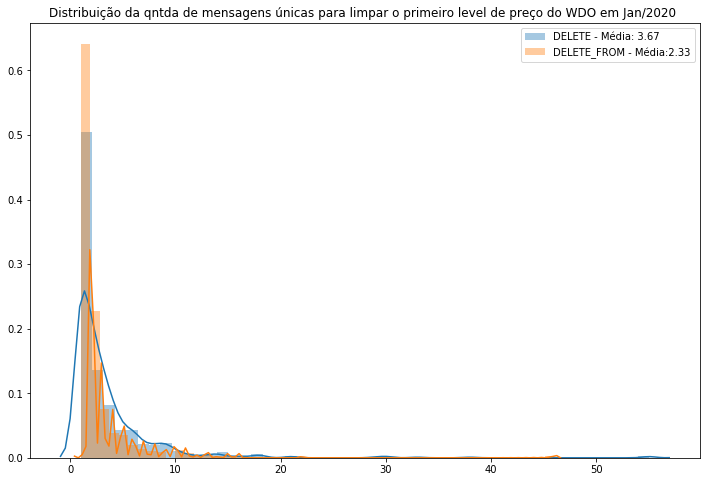

In [11]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(DELETE[0], label = 'DELETE - Média: {:.2f}'.format(np.mean(DELETE[0])))
sns.distplot(FROM[0], label = 'DELETE_FROM - Média:{:.2f}'.format(np.mean(FROM[0])))

ax.set_title('Distribuição da qntda de mensagens únicas para limpar o primeiro level de preço do WDO em Jan/2020 ')

ax.legend()
